<h1><center> How Government Fiscal Relief Affects Employment During 2020 Recession - Case Study of United States </center></h1>

In [3]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import add_constant
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# current working directory should be `./code`, check it:
print(os.getcwd())

GLOBAL_PATH = '../'
RAW_DATA_PATH = 'raw_data/'
PROCESSED_DATA_PATH = 'processed_data/'

/Users/niksun/Desktop/data-repository-partial-code/code


## **Part 1: Merge and Prepare Dataset**

In [8]:
### Read in the datasets ###

df_cps20 = pd.read_csv(GLOBAL_PATH + PROCESSED_DATA_PATH + 'cps2020_aggregate.csv')
df_cps21 = pd.read_csv(GLOBAL_PATH + PROCESSED_DATA_PATH + 'cps2021_aggregate.csv')
df_fiscal = pd.read_csv(GLOBAL_PATH + PROCESSED_DATA_PATH + 'covid_aid.csv')
df_medicaid = pd.read_csv(GLOBAL_PATH + PROCESSED_DATA_PATH + 'medicaid19.csv')
df_gdp = pd.read_csv(GLOBAL_PATH + PROCESSED_DATA_PATH + 'gdp.csv')
df_minwage = pd.read_csv(GLOBAL_PATH + PROCESSED_DATA_PATH + 'minwage.csv')

In [9]:
### Append the 2020 and 2021 CPS datasets ###

# Append the CPS datasets, use concat
df_cps20['Year'] = 2020
df_cps21['Year'] = 2021
df_cps = pd.concat([df_cps20, df_cps21], axis=0)
df_cps.shape

(1224, 13)

In [10]:
### Merge the CPS and with other datasets based on State and Dates ###

# 1. Merge the medicaid dataset with the fiscal aid dataset
df_medicaid_fiscal = pd.merge(df_medicaid, df_fiscal, on='State')
df_medicaid_fiscal.shape # (51, 9)
df_medicaid_fiscal.head()

,State,Medicaid_Year,Medicaid_Services,CHIP,Medicaid_Admin,Medicaid_Total,Award_Obligations,Award_Outlays,Num_Awards
0,Alabama,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743
1,Alaska,2019,2096340139.00,36966548.00,147328880.00,2280635567.00,12200000000.00,10900000000.00,47985
2,Arizona,2019,13167873159.00,234392534.00,314217545.00,13716483238.00,42100000000.00,40100000000.00,335840
3,Arkansas,2019,6842930884.00,189476277.00,400691531.00,7433098692.00,14300000000.00,13500000000.00,165436
4,California,2019,87855979661.00,3650583691.00,6243262727.00,97749826079.00,276400000000.00,252300000000.00,2732743


In [13]:
# 2. Merge the minwage dataset with the gdp dataset
df_minwage_gdp = pd.merge(df_minwage, df_gdp, on='State')
df_minwage_gdp.shape # (51, 33)

df_minwage_gdp = df_minwage_gdp[['State', '2020', '2021', 'GDP20', 'GDP21']]

# rename 2020 and 2021 columns as minwage20 and minwage21

df_minwage_gdp = df_minwage_gdp.rename(columns={'2020': 'minwage20', '2021': 'minwage21'})


df_minwage_gdp.head()

,State,minwage20,minwage21,GDP20,GDP21
0,Alaska,10.19,10.34,50705200000.00,50869400000.00
1,Alabama,7.25,7.25,199880800000.00,209979300000.00
2,Arkansas,10.00,11.00,117268200000.00,123347300000.00
3,Arizona,12.00,12.15,327178000000.00,347656000000.00
4,California,12.00,13.00,2667220900000.00,2874730800000.00


In [14]:
# 3. Merge df_cps and df_medicaid_fiscal on state

# but the state in df_cps is in number format
# so we need to convert the state in df_cps to string

# State_Dict = {1: 'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', 9: 'CT', 10: 'DE', 
#                 11: 'DC', 12: 'FL', 13: 'GA', 15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'IA', 20: 'KS', 
#                 21: 'KY', 22: 'LA', 23: 'ME', 24: 'MD', 25: 'MA', 26: 'MI', 27: 'MN', 28: 'MS', 29: 'MO', 30: 'MT', 
#                 31: 'NE', 32: 'NV', 33: 'NH', 34: 'NJ', 35: 'NM', 36: 'NY', 37: 'NC', 38: 'ND', 39: 'OH', 40: 'OK', 
#                 41: 'OR', 42: 'PA', 44: 'RI', 45: 'SC', 46: 'SD', 47: 'TN', 48: 'TX', 49: 'UT', 50: 'VT', 
#                 51: 'VA', 53: 'WA', 54: 'WV', 55: 'WI', 56: 'WY'}

# state_abbrev = State_Dict.values()

State_dict = {1: 'Alabama', 2: 'Alaska', 4: 'Arizona', 5: 'Arkansas', 6: 'California', 8: 'Colorado', 9: 'Connecticut', 10: 'Delaware',
            11: 'District of Columbia', 12: 'Florida', 13: 'Georgia', 15: 'Hawaii', 16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa', 
            20: 'Kansas', 21: 'Kentucky', 22: 'Louisiana', 23: 'Maine', 24: 'Maryland', 25: 'Massachusetts', 26: 'Michigan', 27: 'Minnesota',
            28: 'Mississippi', 29: 'Missouri', 30: 'Montana', 31: 'Nebraska', 32: 'Nevada', 33: 'New Hampshire', 34: 'New Jersey',
            35: 'New Mexico', 36: 'New York', 37: 'North Carolina', 38: 'North Dakota', 39: 'Ohio', 40: 'Oklahoma', 41: 'Oregon',
            42: 'Pennsylvania', 44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota', 47: 'Tennessee', 48: 'Texas', 49: 'Utah',
            50: 'Vermont', 51: 'Virginia', 53: 'Washington', 54: 'West Virginia', 55: 'Wisconsin', 56: 'Wyoming'}

df_cps['State'] = df_cps['State'].map(State_dict)

df_cps_medicaid_fiscal = pd.merge(df_cps, df_medicaid_fiscal, on='State')
df_cps_medicaid_fiscal.shape # (1224, 22) 1224 = 51 * 12 * 2

(1224, 21)

In [16]:
df_cps_medicaid_fiscal.head()
# remove Unnamed: 0 column
# df_cps_medicaid_fiscal = df_cps_medicaid_fiscal.drop(columns=['Unnamed: 0'])

,Month,State,Civil_Pop,LaborForce_Pop,Unemp_Pop,Emp_Pop,Emp_Rate,Unemp_Rate,LF_Particip_Rate,Emp_Pop_Ratio,Union_Pop,Union_Rate,Year,Medicaid_Year,Medicaid_Services,CHIP,Medicaid_Admin,Medicaid_Total,Award_Obligations,Award_Outlays,Num_Awards
0,1,Alabama,3871113.00,2191401.22,71895.19,2119506.03,96.72,3.28,56.61,54.75,87503.61,3.99,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743
1,2,Alabama,3872005.99,2204607.21,54473.34,2150133.87,97.53,2.47,56.94,55.53,154302.94,7.00,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743
2,3,Alabama,3873022.00,2201768.39,71239.63,2130528.76,96.76,3.24,56.85,55.01,205893.23,9.35,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743
3,4,Alabama,3874113.00,2169831.96,295493.15,1874338.81,86.38,13.62,56.01,48.38,170584.20,7.86,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743
4,5,Alabama,3875399.00,2241936.94,203557.90,2038379.03,90.92,9.08,57.85,52.60,173450.71,7.74,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743


In [19]:
# 4. Merge df_cps_medicaid_fiscal and df_minwage_gdp on state
df_final = pd.merge(df_cps_medicaid_fiscal, df_minwage_gdp, on='State')
df_final.shape # (1224, 26)

# if df_cps_medicaid_fiscal Year is 2020, then use MinWage20 and GDP20 from df_minwage_gdp
# if df_cps_medicaid_fiscal Year is 2021, then use MinWage21 and GDP21 from df_minwage_gdp
df_final['MinWage'] = np.where(df_final['Year'] == 2020, df_final['minwage20'], df_final['minwage21'])
df_final['GDP'] = np.where(df_final['Year'] == 2020, df_final['GDP20'], df_final['GDP21'])

# drop MinWage20, MinWage21, GDP20, GDP21
df_final = df_final.drop(columns=['minwage20', 'minwage21', 'GDP20', 'GDP21'])

# check columns
df_final.columns


Index(['Month', 'State', 'Civil_Pop', 'LaborForce_Pop', 'Unemp_Pop', 'Emp_Pop',
       'Emp_Rate', 'Unemp_Rate', 'LF_Particip_Rate', 'Emp_Pop_Ratio',
       'Union_Pop', 'Union_Rate', 'Year', 'Medicaid_Year', 'Medicaid_Services',
       'CHIP', 'Medicaid_Admin', 'Medicaid_Total', 'Award_Obligations',
       'Award_Outlays', 'Num_Awards', 'MinWage', 'GDP'],
      dtype='object')

In [20]:
df_final.head()

,Month,State,Civil_Pop,LaborForce_Pop,Unemp_Pop,Emp_Pop,Emp_Rate,Unemp_Rate,LF_Particip_Rate,Emp_Pop_Ratio,Union_Pop,Union_Rate,Year,Medicaid_Year,Medicaid_Services,CHIP,Medicaid_Admin,Medicaid_Total,Award_Obligations,Award_Outlays,Num_Awards,MinWage,GDP
0,1,Alabama,3871113.00,2191401.22,71895.19,2119506.03,96.72,3.28,56.61,54.75,87503.61,3.99,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00
1,2,Alabama,3872005.99,2204607.21,54473.34,2150133.87,97.53,2.47,56.94,55.53,154302.94,7.00,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00
2,3,Alabama,3873022.00,2201768.39,71239.63,2130528.76,96.76,3.24,56.85,55.01,205893.23,9.35,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00
3,4,Alabama,3874113.00,2169831.96,295493.15,1874338.81,86.38,13.62,56.01,48.38,170584.20,7.86,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00
4,5,Alabama,3875399.00,2241936.94,203557.90,2038379.03,90.92,9.08,57.85,52.60,173450.71,7.74,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00


In [21]:
# save the final data
df_final.to_csv(GLOBAL_PATH + PROCESSED_DATA_PATH + 'case_study.csv', index=False)

## **Part 2: Data Visualization**

In [22]:
df = pd.read_csv(GLOBAL_PATH + PROCESSED_DATA_PATH + 'case_study.csv')
df.head()

,Month,State,Civil_Pop,LaborForce_Pop,Unemp_Pop,Emp_Pop,Emp_Rate,Unemp_Rate,LF_Particip_Rate,Emp_Pop_Ratio,Union_Pop,Union_Rate,Year,Medicaid_Year,Medicaid_Services,CHIP,Medicaid_Admin,Medicaid_Total,Award_Obligations,Award_Outlays,Num_Awards,MinWage,GDP
0,1,Alabama,3871113.00,2191401.22,71895.19,2119506.03,96.72,3.28,56.61,54.75,87503.61,3.99,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00
1,2,Alabama,3872005.99,2204607.21,54473.34,2150133.87,97.53,2.47,56.94,55.53,154302.94,7.00,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00
2,3,Alabama,3873022.00,2201768.39,71239.63,2130528.76,96.76,3.24,56.85,55.01,205893.23,9.35,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00
3,4,Alabama,3874113.00,2169831.96,295493.15,1874338.81,86.38,13.62,56.01,48.38,170584.20,7.86,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00
4,5,Alabama,3875399.00,2241936.94,203557.90,2038379.03,90.92,9.08,57.85,52.60,173450.71,7.74,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00


In [23]:
# create a new column for period called 'Period'
# if Year = 2020 and Month = 1, Period = 1
# if Year = 2020 and Month = 2, Period = 2
# .... if Year = 2020 and Month = 12, Period = 12
# if Year = 2021 and Month = 1, Period = 13
# if Year = 2021 and Month = 2, Period = 14
# .... if Year = 2021 and Month = 12, Period = 24

df['Period'] = (df['Year'] - 2020) * 12 + df['Month']

In [24]:
df_2020 = df[df['Year'] == 2020]
df_2021 = df[df['Year'] == 2021]

### 1.1 graphs for Fiscal Aid in each state

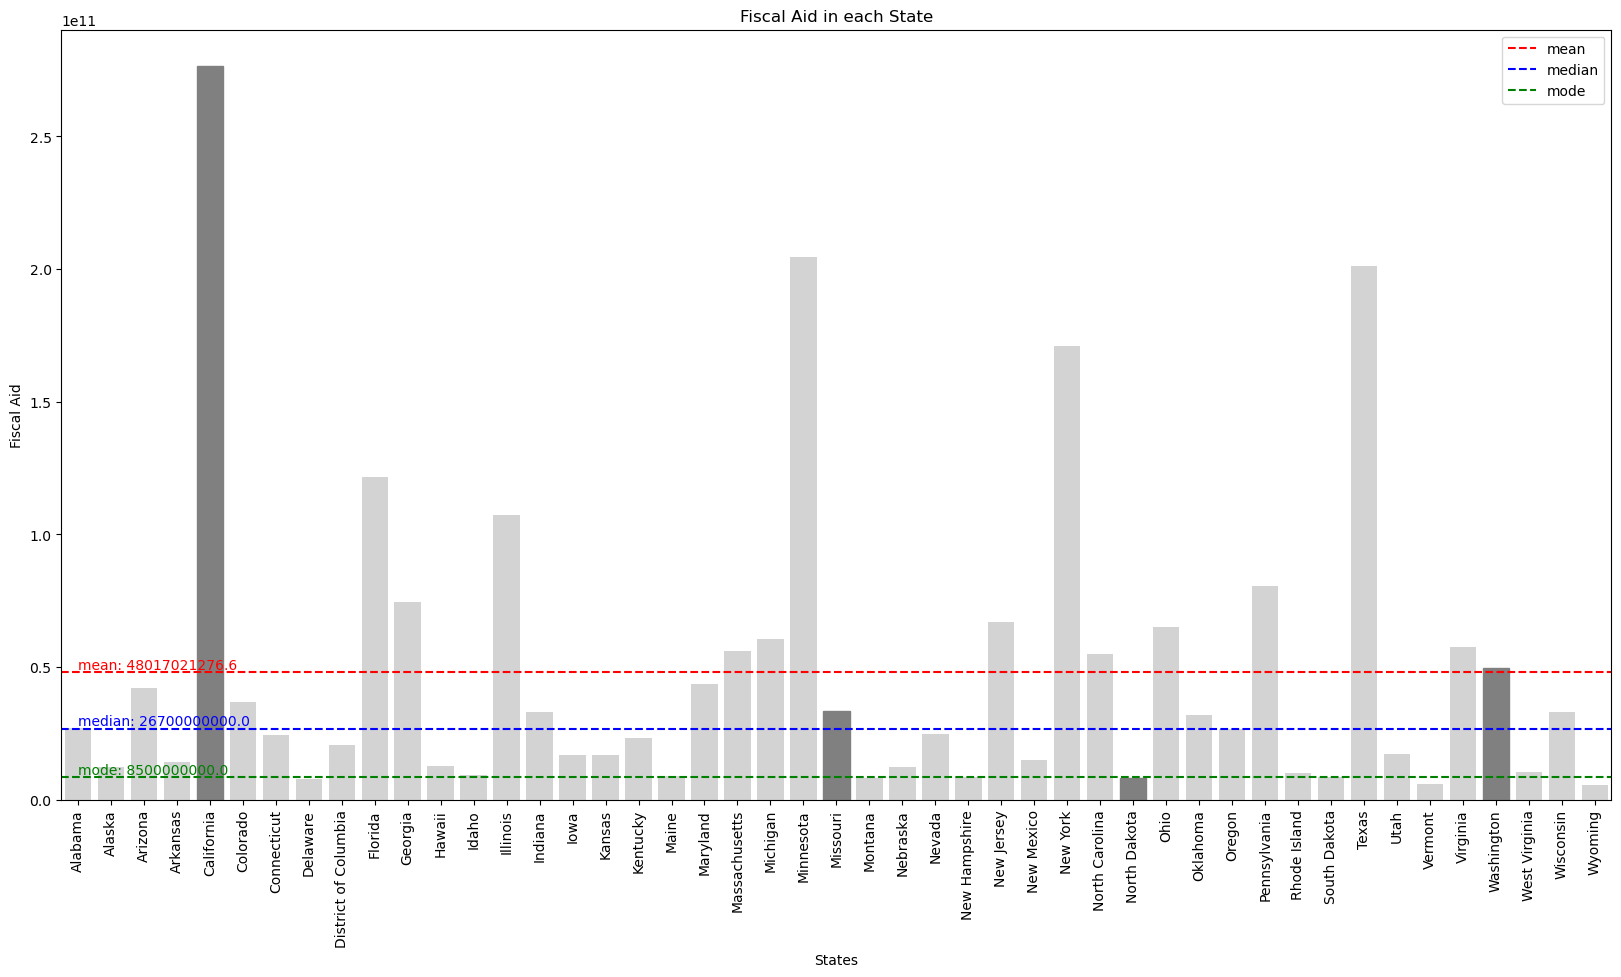

In [25]:
# Award_Obligations in each State
plt.figure(figsize=(20, 10))
sns.barplot(x='State', y='Award_Obligations', data=df, color='lightgray')

award_obligations_mean = df['Award_Obligations'].mean()
plt.axhline(award_obligations_mean, color='r', linestyle='--', label='mean')
plt.text(0, award_obligations_mean, 'mean: '+str(round(award_obligations_mean, 2)), color='r', va='bottom')
award_obligations_median = df['Award_Obligations'].median()
plt.axhline(award_obligations_median, color='b', linestyle='--', label='median')
plt.text(0, award_obligations_median, 'median: '+str(round(award_obligations_median, 2)), color='b', va='bottom')
award_obligations_mode = df['Award_Obligations'].mode()[0]
plt.axhline(award_obligations_mode, color='g', linestyle='--', label='mode')
plt.text(0, award_obligations_mode, 'mode: '+str(round(award_obligations_mode, 2)), color='g', va='bottom')

for i, bar in enumerate(plt.gca().patches):
    if i in [4, 23, 32, 43]:
        bar.set_color('gray')

plt.legend()
plt.xlabel('States')
plt.ylabel('Fiscal Aid')
plt.title('Fiscal Aid in each State')
plt.xticks(rotation=90)
plt.show()

# there are 12 months, but since the dollar amount is the same, python seems dealed with it as 1 month

### Questions: 

How much does each state get? Did they receive the same? If not, which states receive more fund?

Summary of observation: 

We can see from the chart that the highest four bars representing CA, Minn, TX, and NY received top four relief funds.
Was it because of a. The number of total population in each state? B. the severity of Covid-19 (population ratio) c. the severity of unemployment (employment ratio)?
This bar chart doesn’t tell us.

### Fiscal Aid per Person in each state

How much aid does each person receive in each state? Do they receive the same amount? If not, in which state each person receives more?

Summary of observation: 

We can see from the chart that the highest four bars represent Minn, District of Columbia, and Alaska. Different from the results from the bar chart 1.
The bar chart doesn’t tell us why each person in these three states receive more fund.


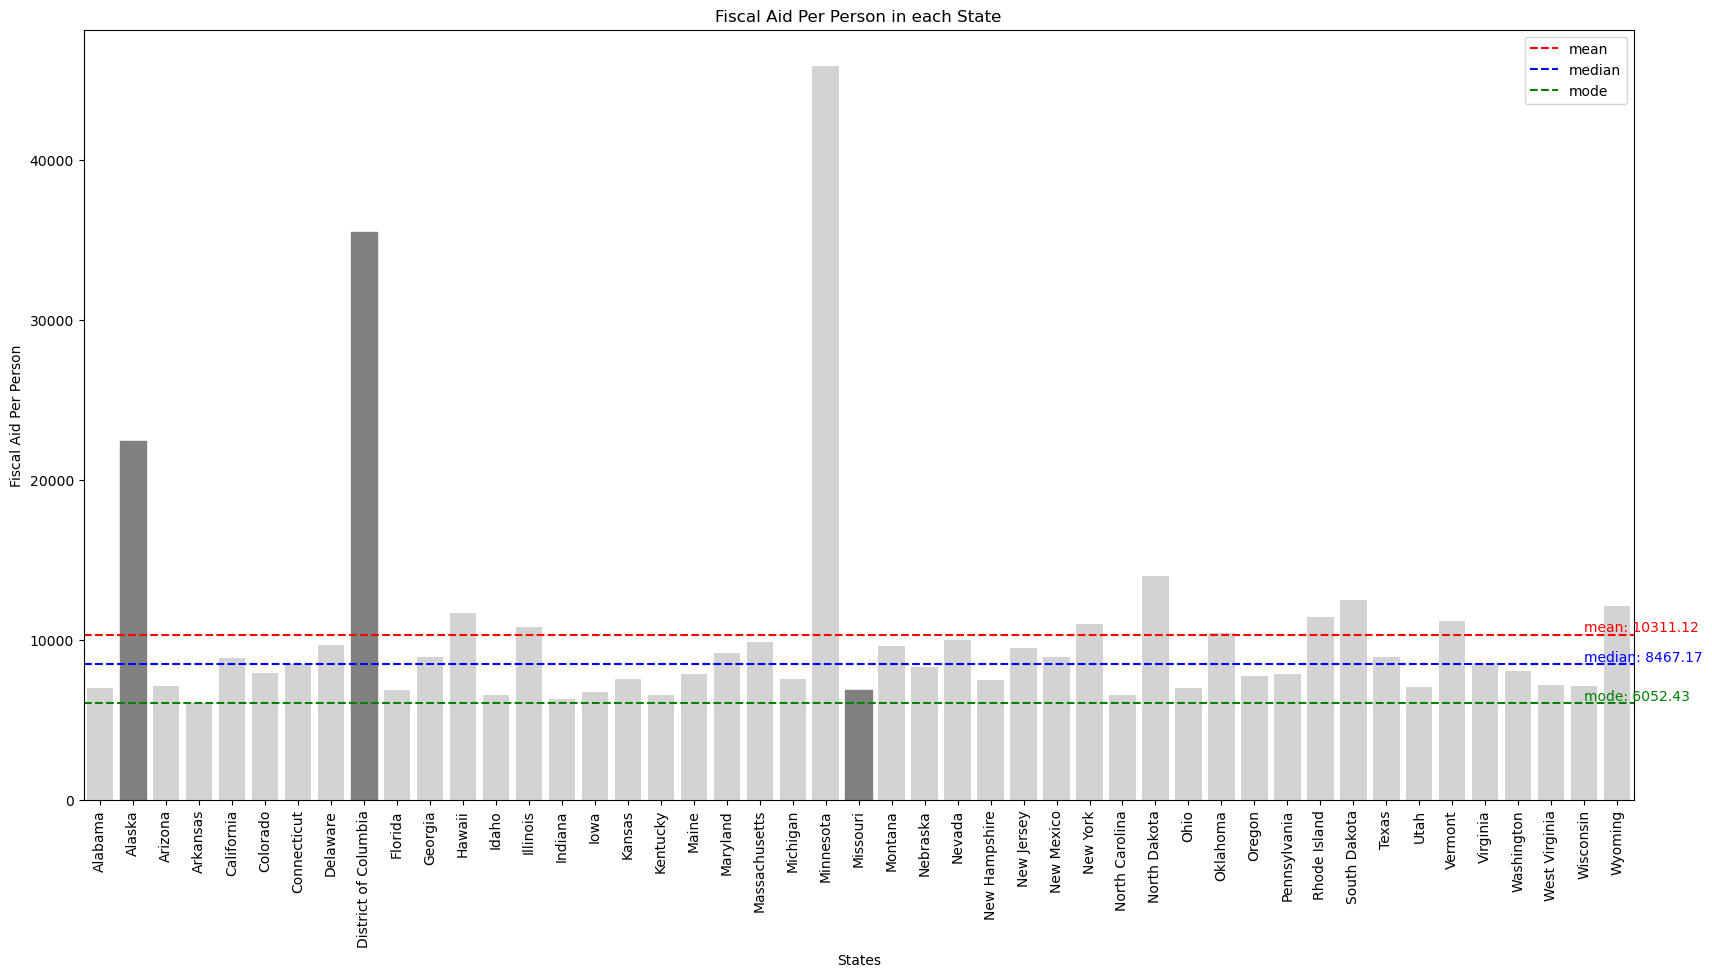

In [26]:
# mean of the population in each State over 12 months
df['Civil_Pop_mean'] = df.groupby('State')['Civil_Pop'].transform('mean')
# normalize the Award_Obligations by the mean of the population in each State over 12 months
df['Award_Obligations_norm'] = df['Award_Obligations'] / df['Civil_Pop_mean']

plt.figure(figsize=(20, 10))
sns.barplot(x='State', y='Award_Obligations_norm', data=df, color='lightgray')

award_obligations_norm_mean = df['Award_Obligations_norm'].mean()
plt.axhline(award_obligations_norm_mean, color='r', linestyle='--', label='mean')
plt.text(45, award_obligations_norm_mean, 'mean: '+str(round(award_obligations_norm_mean, 2)), color='r', va='bottom')
award_obligations_norm_median = df['Award_Obligations_norm'].median()
plt.axhline(award_obligations_norm_median, color='b', linestyle='--', label='median')
plt.text(45, award_obligations_norm_median, 'median: '+str(round(award_obligations_norm_median, 2)), color='b', va='bottom')
award_obligations_norm_mode = df['Award_Obligations_norm'].mode()[0]
plt.axhline(award_obligations_norm_mode, color='g', linestyle='--', label='mode')
plt.text(45, award_obligations_norm_mode, 'mode: '+str(round(award_obligations_norm_mode, 2)), color='g', va='bottom')

for i, bar in enumerate(plt.gca().patches):
    if i in [1, 8, 23]:
        bar.set_color('gray')

plt.legend()
plt.title('Fiscal Aid Per Person in each State')
plt.xlabel('States')
plt.ylabel('Fiscal Aid Per Person')
plt.xticks(rotation=90)
plt.show()


##@ 1.2 graphs for Instrument: Medicaid in each state

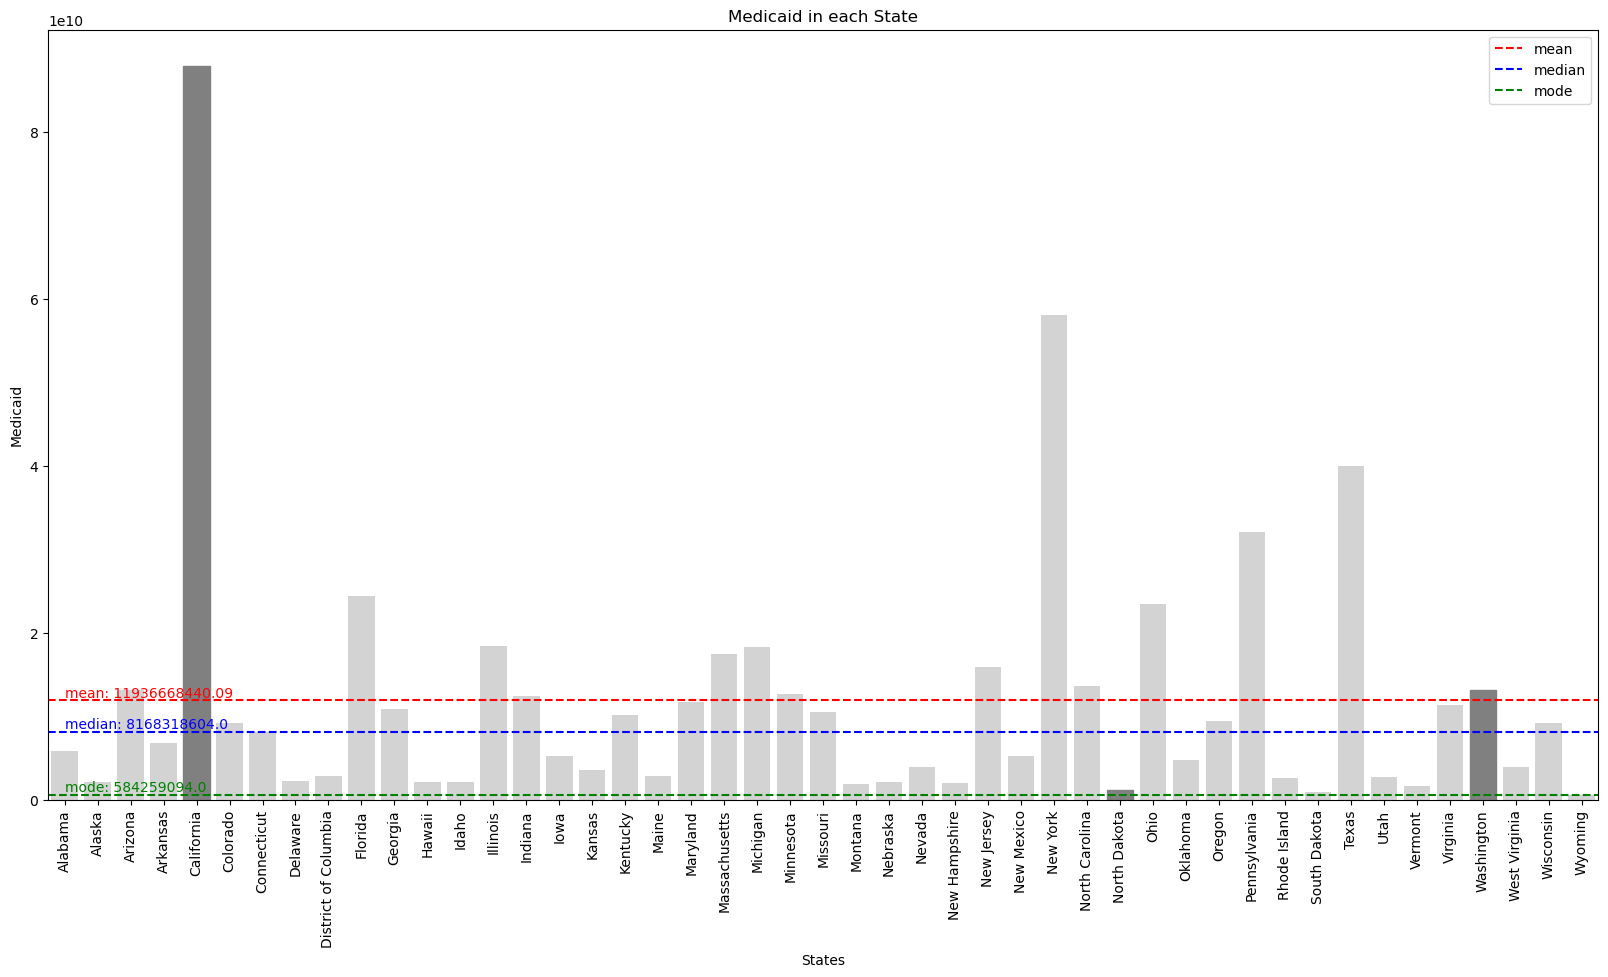

In [27]:
plt.figure(figsize=(20, 10))
sns.barplot(x='State', y='Medicaid_Services', data=df, color='lightgray')

total_mean = df['Medicaid_Services'].mean()
plt.axhline(total_mean, color='r', linestyle='--', label='mean')
plt.text(0, total_mean, 'mean: '+str(round(total_mean, 2)), color='r', va='bottom')
total_median = df['Medicaid_Services'].median()
plt.axhline(total_median, color='b', linestyle='--', label='median')
plt.text(0, total_median, 'median: '+str(round(total_median, 2)), color='b', va='bottom')
total_mode = df['Medicaid_Services'].mode()[0]
plt.axhline(total_mode, color='g', linestyle='--', label='mode')
plt.text(0, total_mode, 'mode: '+str(round(total_mode, 2)), color='g', va='bottom')

for i, bar in enumerate(plt.gca().patches):
    if i in [4, 32, 43]:
        bar.set_color('gray')

plt.legend()
plt.xlabel('States')
plt.title('Medicaid in each State')
plt.ylabel('Medicaid')
plt.xticks(rotation=90)
plt.show()

Question:

How much medicaid does each state get? Did they receive the same? If not, which states receive more fund?

We can see from the chart that the highest four bars represent CA, MI, TX. Different than the bar chart 1 shows, MI is not on the top four list.

The bar chart doesn’t tell why CA, MI, TX received more medicaid. Why MI was not top four.


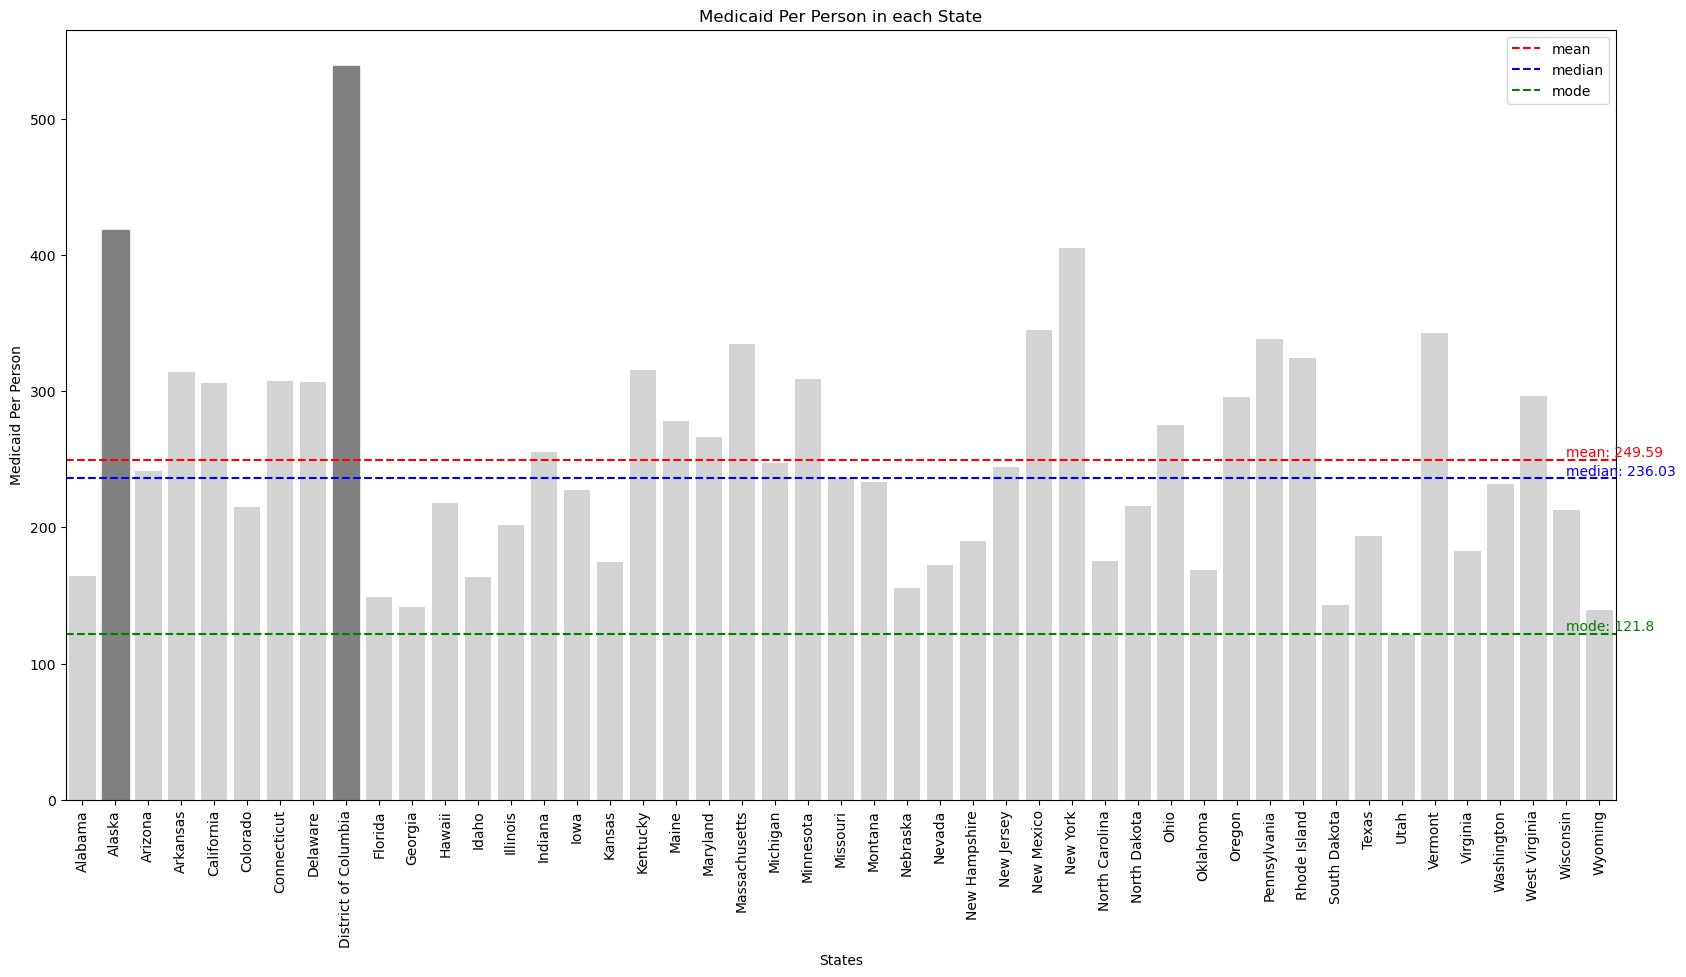

In [28]:
# normalize the Total by the mean of the population in each State over 12 months
# df['Medicaid_Services_norm'] = df['Medicaid_Services'] / df['Civil_Pop_mean']
df['Medicaid_Services_norm'] = (df['Medicaid_Services'] * 0.062 * 21 / 12) / df['Civil_Pop_mean']


plt.figure(figsize=(20, 10))
sns.barplot(x='State', y='Medicaid_Services_norm', data=df, color='lightgray')

total_norm_mean = df['Medicaid_Services_norm'].mean()
plt.axhline(total_norm_mean, color='r', linestyle='--', label='mean')
plt.text(45, total_norm_mean, 'mean: '+str(round(total_norm_mean, 2)), color='r', va='bottom')
total_norm_median = df['Medicaid_Services_norm'].median()
plt.axhline(total_norm_median, color='b', linestyle='--', label='median')
plt.text(45, total_norm_median, 'median: '+str(round(total_norm_median, 2)), color='b', va='bottom')
total_norm_mode = df['Medicaid_Services_norm'].mode()[0]
plt.axhline(total_norm_mode, color='g', linestyle='--', label='mode')
plt.text(45, total_norm_mode, 'mode: '+str(round(total_norm_mode, 2)), color='g', va='bottom')

for i, bar in enumerate(plt.gca().patches):
    if i in [1, 8]:
        bar.set_color('gray')

plt.legend()
plt.title('Medicaid Per Person in each State')
plt.xlabel('States')
plt.ylabel('Medicaid Per Person')
plt.xticks(rotation=90)
plt.show()


## 1.3 Mapping

We can use Tableau to map the data. 

Try later to map the data in Python.

## 1.4 Trend in employment rate

potentially add 2021 and 2022 data for longer term trend

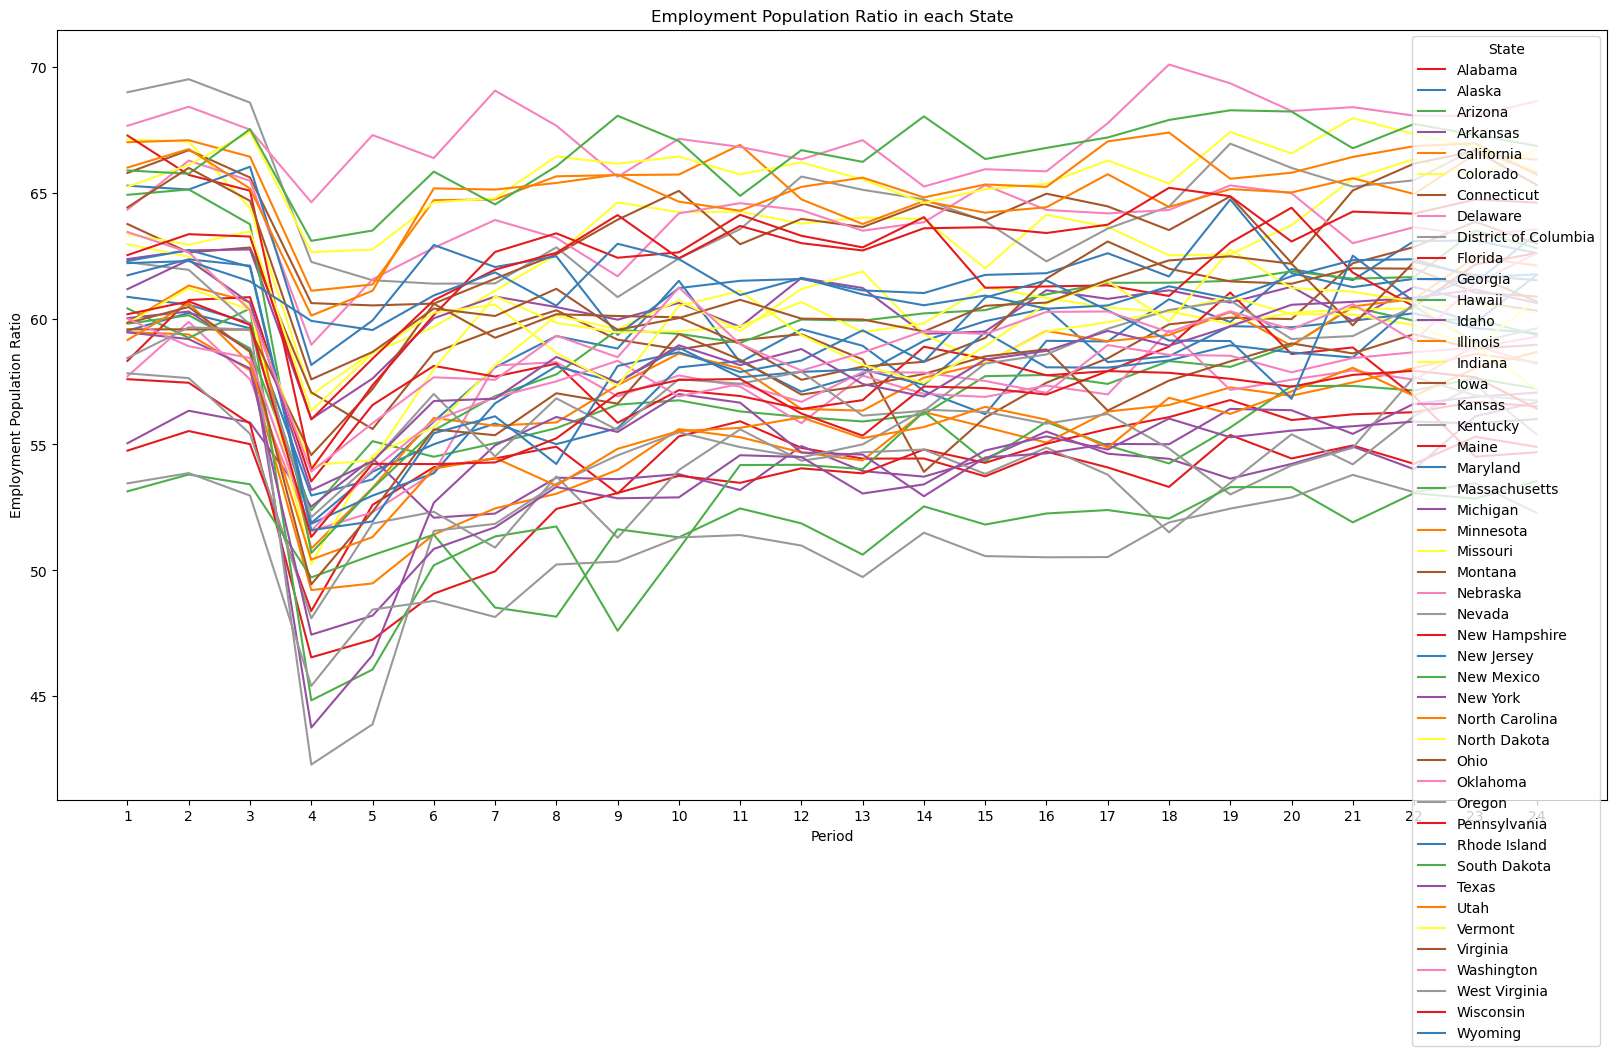

In [29]:
# we want to see the trend in Emp_Pop_Ratio over 12 months for each State
# plot the Emp_Pop_Ratio over 12 months for each State, limit year to 2020
# show all Period 1-24 values on x-axis, instead of 5 gaps
plt.figure(figsize=(20, 10))
sns.lineplot(x='Period', y='Emp_Pop_Ratio', hue='State', data=df, palette='Set1')
plt.title('Employment Population Ratio in each State')
plt.xlabel('Period')
plt.ylabel('Employment Population Ratio')
plt.xticks(np.arange(1, 25, 1))
plt.show()


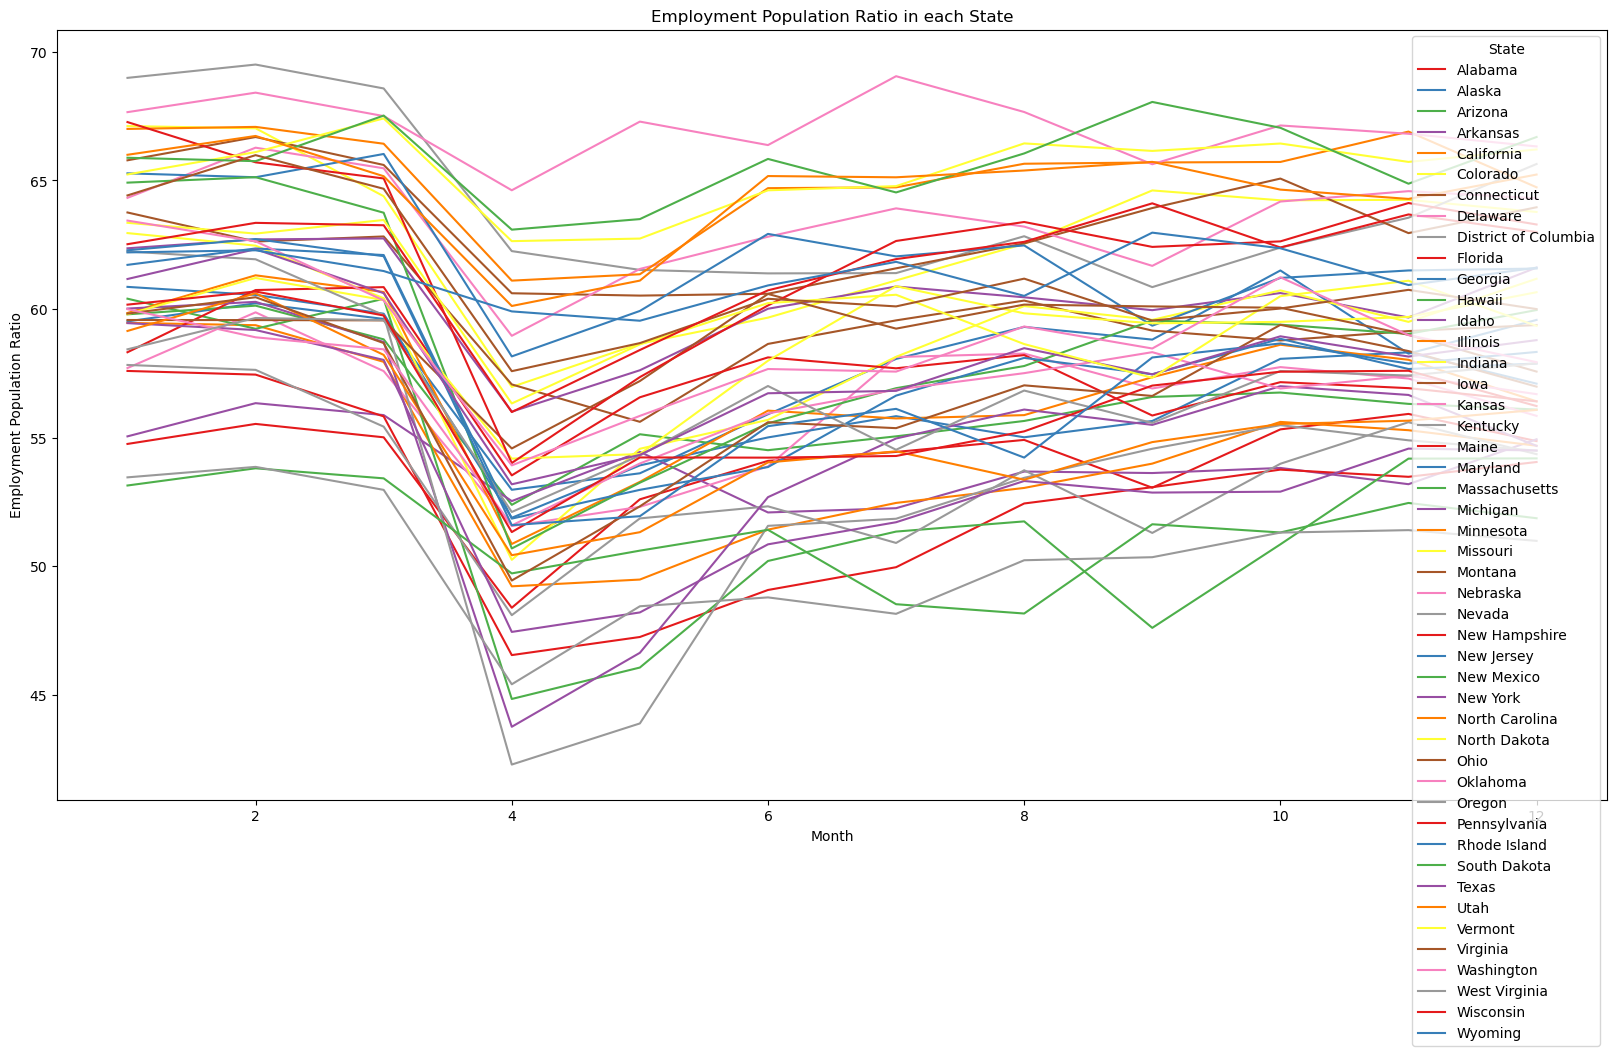

In [30]:

plt.figure(figsize=(20, 10))
sns.lineplot(x='Month', y='Emp_Pop_Ratio', hue='State', data=df_2020, palette='Set1')
plt.title('Employment Population Ratio in each State')
plt.xlabel('Month')
plt.ylabel('Employment Population Ratio')
plt.show()

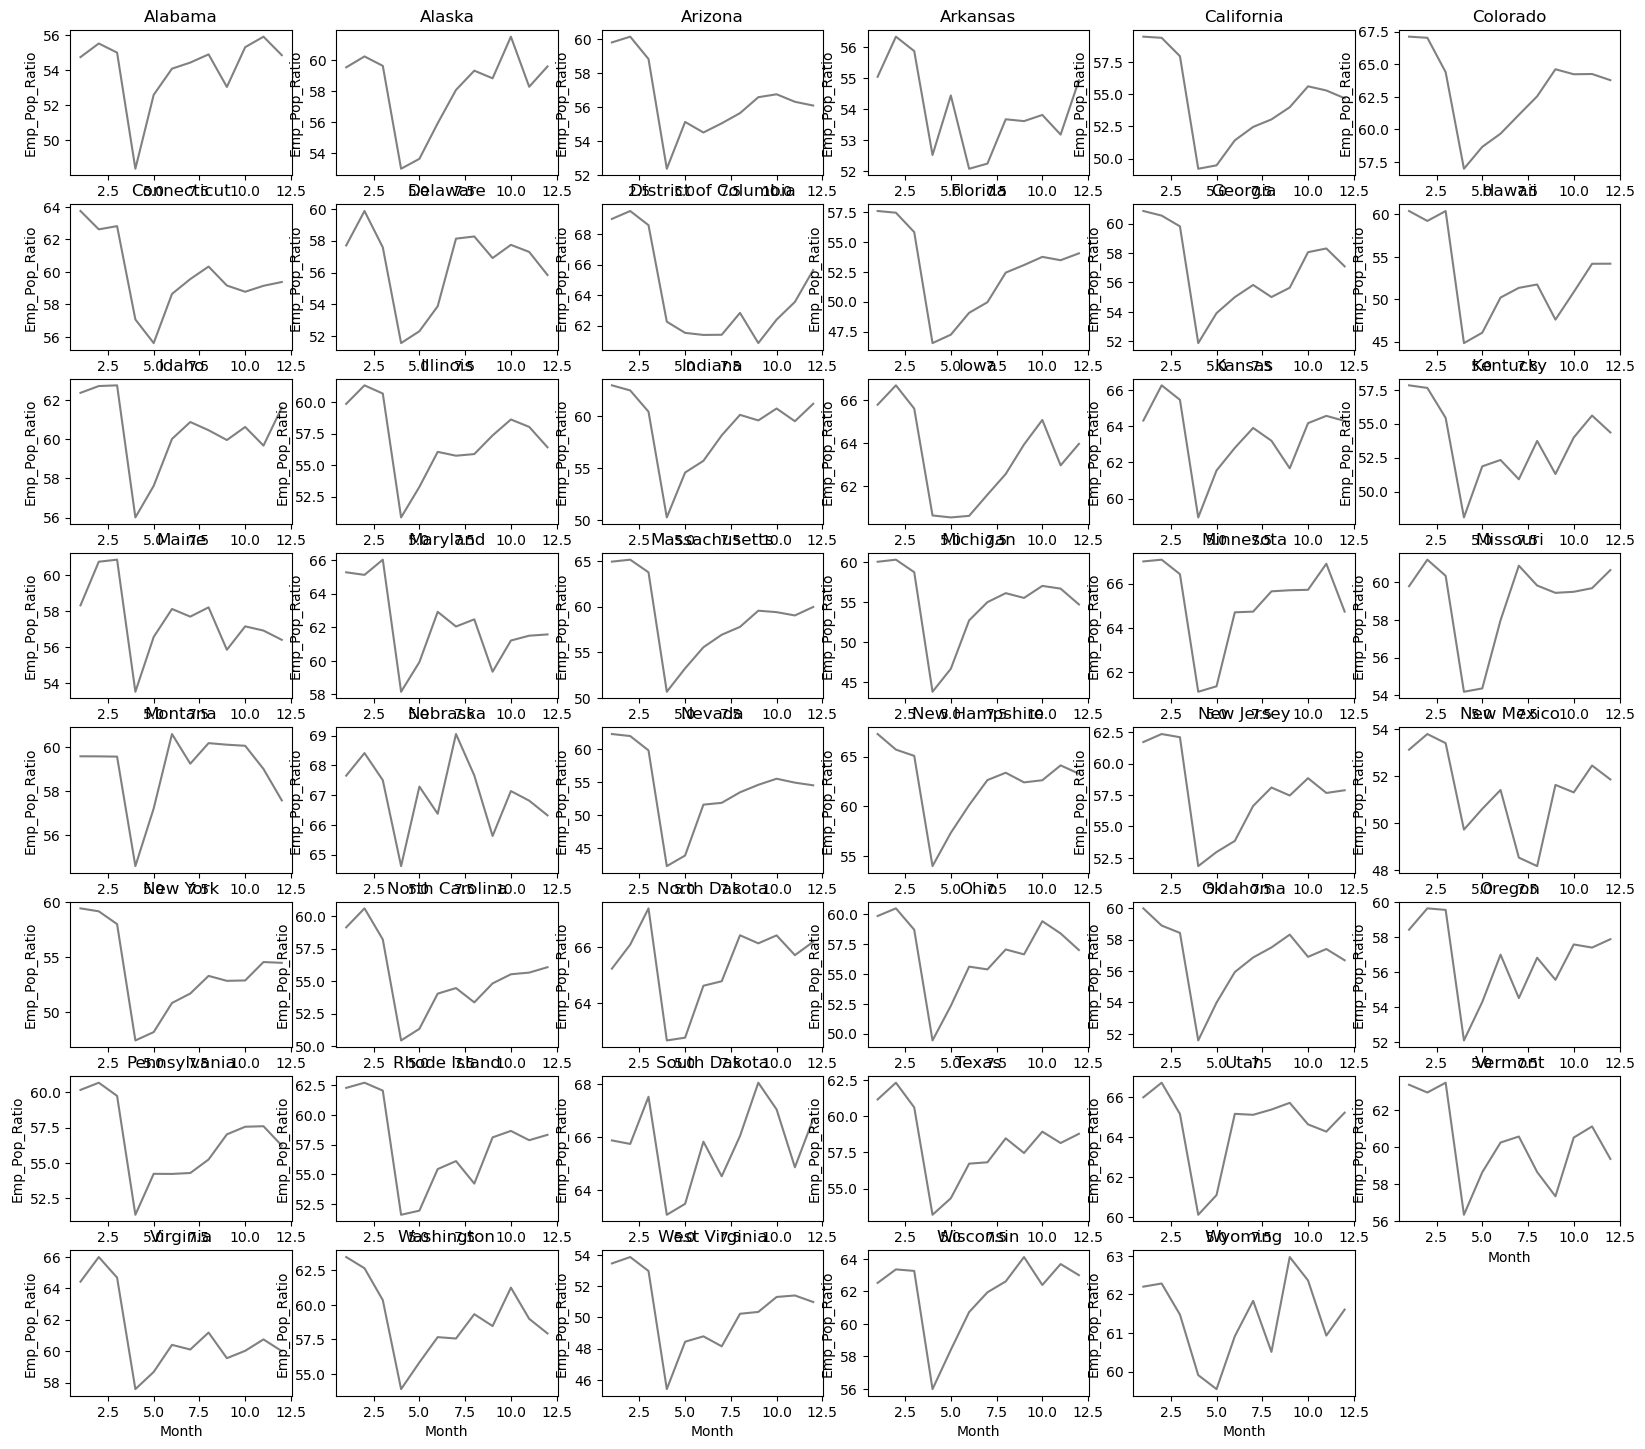

In [31]:
# we want to see the trend in Emp_Pop_Ratio over 12 months for each State
# plot the Emp_Pop_Ratio over 12 months for each State
# use subplot to plot the Emp_Pop_Ratio over 12 months for each State

plt.figure(figsize=(20, 20))
for i, state in enumerate(df['State'].unique()):
    plt.subplot(9, 6, i+1)
    sns.lineplot(x='Month', y='Emp_Pop_Ratio', data=df_2020[df_2020['State']==state], color='gray')
    plt.title(state)
plt.show()



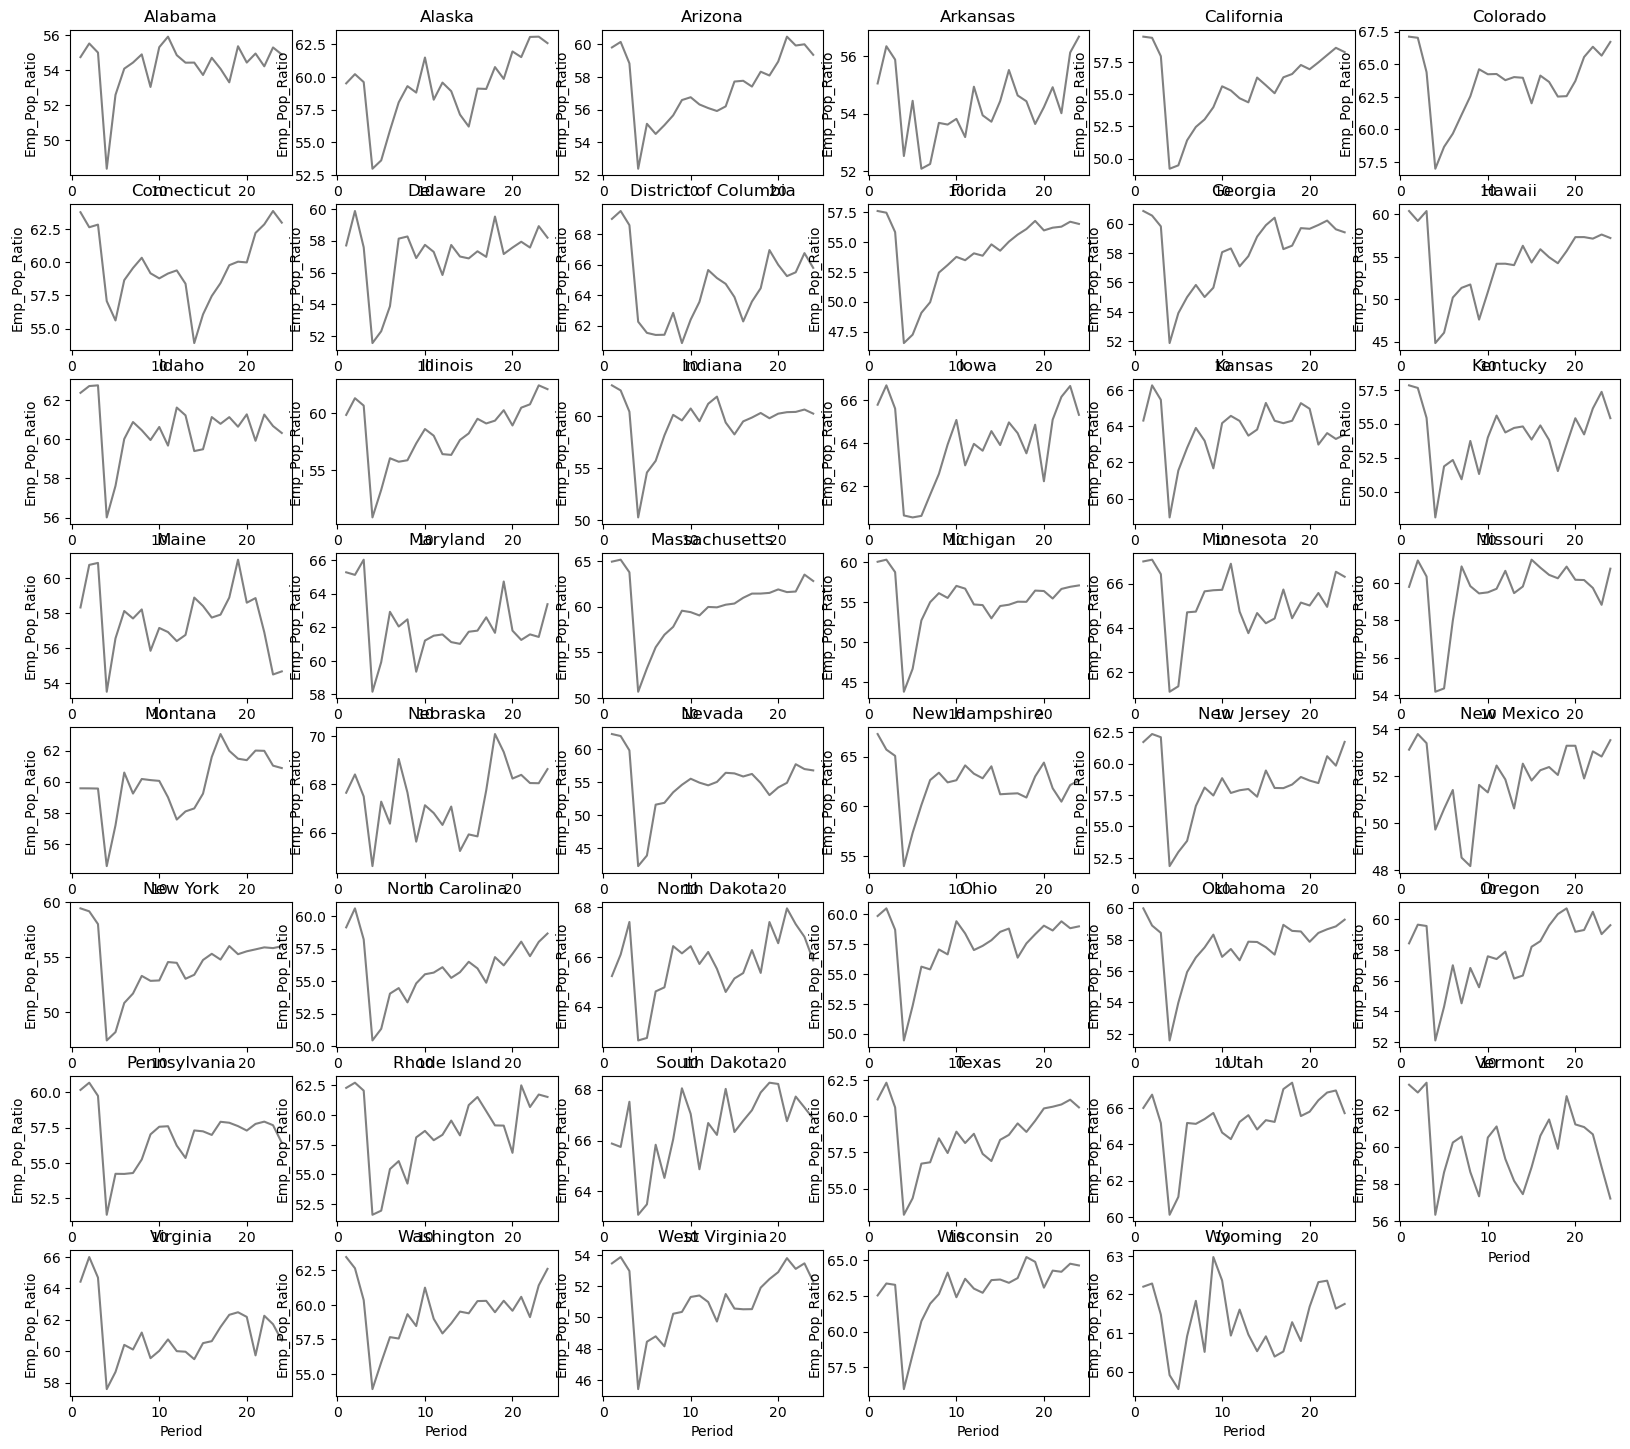

In [32]:
plt.figure(figsize=(20, 20))
for i, state in enumerate(df['State'].unique()):
    plt.subplot(9, 6, i+1)
    sns.lineplot(x='Period', y='Emp_Pop_Ratio', data=df[df['State']==state], color='gray')
    plt.title(state)
plt.show()

In [33]:
# drop unnecessary columns
# drop Civil_Pop_mean, Award_Obligations_norm, Medicaid_Services_norm
df.drop(['Civil_Pop_mean', 'Award_Obligations_norm', 'Medicaid_Services_norm'], axis=1, inplace=True)

In [34]:
df.head()

,Month,State,Civil_Pop,LaborForce_Pop,Unemp_Pop,Emp_Pop,Emp_Rate,Unemp_Rate,LF_Particip_Rate,Emp_Pop_Ratio,Union_Pop,Union_Rate,Year,Medicaid_Year,Medicaid_Services,CHIP,Medicaid_Admin,Medicaid_Total,Award_Obligations,Award_Outlays,Num_Awards,MinWage,GDP,Period
0,1,Alabama,3871113.00,2191401.22,71895.19,2119506.03,96.72,3.28,56.61,54.75,87503.61,3.99,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00,1
1,2,Alabama,3872005.99,2204607.21,54473.34,2150133.87,97.53,2.47,56.94,55.53,154302.94,7.00,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00,2
2,3,Alabama,3873022.00,2201768.39,71239.63,2130528.76,96.76,3.24,56.85,55.01,205893.23,9.35,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00,3
3,4,Alabama,3874113.00,2169831.96,295493.15,1874338.81,86.38,13.62,56.01,48.38,170584.20,7.86,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00,4
4,5,Alabama,3875399.00,2241936.94,203557.90,2038379.03,90.92,9.08,57.85,52.60,173450.71,7.74,2020,2019,5880233770.00,391366847.00,216223796.00,6487824413.00,27100000000.00,24600000000.00,297743,7.25,199880800000.00,5


# 2. Modelling

## Model 1: Simple Linear Regression

Change in employment-population-ration from t0 to t1 for each state as dependent variable

Award_Outlays(billions) as independent variable

In [35]:
def simple_regression(dataset, end_period):
    df = dataset.copy()
    df_start = df[df['Period'] == 4].reset_index(drop=True)
    table = pd.DataFrame()
    for p in range(5, end_period+1):
        df_end = df[df['Period'] == p].reset_index(drop=True)
        df_start_end = df_end.copy()
        df_start_end.iloc[:, 4:10] = df_end.iloc[:, 4:10].values - df_start.iloc[:, 4:10].values
        df_start_end.reset_index(drop=True, inplace=True)
        df_start_end['normAid'] = df_start_end['Award_Outlays']/df_start_end['Civil_Pop']/10_000
        df_start_end['normGDP'] = df_start_end['GDP']/df_start_end['Civil_Pop'] / 1_0000
        df_start_end['LaborForce_Pop'] = df_start_end['LaborForce_Pop']/ 1000_000
        X = df_start_end[['normAid', 'normGDP', 'Union_Pop', 'LaborForce_Pop', 'MinWage']]
        y = df_start_end['Emp_Pop_Ratio']
        # y = df_start_end['Unemp_Pop']
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        # use concat to add a row to the table
        print(model.summary())
        table = pd.concat([table, pd.DataFrame({'Period': [p], 
                                                'coeff on normAid': [model.params[1]],
                                                'p-value on normAid': [model.pvalues[1]],
                                                'std err on normAid': [model.bse[1]],
                                                'R2': [model.rsquared],
                                                'Adj R2': [model.rsquared_adj],
                                                'F-statistic': [model.fvalue],
                                                'No. Observations': [model.nobs]})], ignore_index=True)
    return table

In [36]:

simple_regression(df, 24)

                            OLS Regression Results                            
Dep. Variable:          Emp_Pop_Ratio   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2.636
Date:                Mon, 08 May 2023   Prob (F-statistic):             0.0372
Time:                        18:55:15   Log-Likelihood:                -71.860
No. Observations:                  47   AIC:                             155.7
Df Residuals:                      41   BIC:                             166.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.4528      0.922      3.

,Period,coeff on normAid,p-value on normAid,std err on normAid,R2,Adj R2,F-statistic,No. Observations
0,5,-0.41,0.20,0.31,0.24,0.15,2.64,47.00
1,6,0.10,0.84,0.49,0.22,0.12,2.30,47.00
2,7,-0.13,0.83,0.64,0.10,-0.01,0.87,47.00
3,8,-0.18,0.80,0.69,0.09,-0.02,0.83,47.00
4,9,-0.01,0.99,0.70,0.15,0.04,1.42,47.00
5,10,-0.11,0.88,0.70,0.15,0.04,1.42,47.00
6,11,0.25,0.72,0.70,0.16,0.06,1.57,47.00
7,12,-0.34,0.61,0.67,0.08,-0.03,0.71,47.00
8,13,-0.64,0.39,0.73,0.06,-0.05,0.57,47.00
9,14,-0.30,0.71,0.81,0.10,-0.01,0.94,47.00


## Model 2:  2-Stage Least Squares

In [37]:
# stage 1: regression normAid on Medicaid_Services

def stage_1_reg(dataset, end_period):
    df = dataset.copy()
    df_start = df[df['Period'] == 4].reset_index(drop=True)
    table = pd.DataFrame()
    for p in range(5, end_period+1):
        df_end = df[df['Period'] == p].reset_index(drop=True)
        df_start_end = df_end.copy()
        df_start_end.iloc[:, 4:10] = df_end.iloc[:, 4:10].values - df_start.iloc[:, 4:10].values
        df_start_end.reset_index(drop=True, inplace=True)
        df_start_end['normAid'] = df_start_end['Award_Outlays']/df_start_end['Civil_Pop']/10_000
        df_start_end['Medicaid_Services'] = df_start_end['Medicaid_Services']/df_start_end['Civil_Pop']/10_000
        df_start_end['normGDP'] = df_start_end['GDP']/df_start_end['Civil_Pop'] / 1_0000
        df_start_end['LaborForce_Pop'] = df_start_end['LaborForce_Pop']/ 1000_000
        # # dependent variable: Emp_Pop_Ratio
        # Independent variable: normAid, normGDP, Union_Pop, Labor_Force_Pop
        X = df_start_end[['Medicaid_Services', 'normGDP', 'Union_Pop', 'LaborForce_Pop', 'MinWage', 'Emp_Pop']]
        y = df_start_end['normAid']
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        # use concat to add a row to the table
        print(model.summary())
        table = pd.concat([table, pd.DataFrame({'Period': [p], 
                                                'coeff on Medicaid_Services': [model.params[1]],
                                                'p-value on Medicaid_Services': [model.pvalues[1]],
                                                'std err on Medicaid_Services': [model.bse[1]],
                                                'R2': [model.rsquared],
                                                'Adj R2': [model.rsquared_adj],
                                                'F-statistic': [model.fvalue],
                                                'No. Observations': [model.nobs]})], ignore_index=True)
    return table

In [38]:
stage_1_reg(df, 24)

                            OLS Regression Results                            
Dep. Variable:                normAid   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     3.850
Date:                Mon, 08 May 2023   Prob (F-statistic):            0.00400
Time:                        18:55:16   Log-Likelihood:                -37.369
No. Observations:                  47   AIC:                             88.74
Df Residuals:                      40   BIC:                             101.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0345      0.46

,Period,coeff on Medicaid_Services,p-value on Medicaid_Services,std err on Medicaid_Services,R2,Adj R2,F-statistic,No. Observations
0,5,2.25,0.14,1.52,0.37,0.27,3.85,47.00
1,6,1.81,0.25,1.55,0.33,0.23,3.34,47.00
2,7,1.80,0.25,1.54,0.34,0.24,3.37,47.00
3,8,1.63,0.29,1.52,0.34,0.24,3.41,47.00
4,9,1.59,0.31,1.56,0.34,0.24,3.38,47.00
5,10,1.56,0.32,1.53,0.34,0.24,3.43,47.00
6,11,2.09,0.18,1.53,0.35,0.25,3.51,47.00
7,12,1.74,0.26,1.51,0.34,0.24,3.48,47.00
8,13,1.93,0.22,1.55,0.34,0.25,3.49,47.00
9,14,2.03,0.19,1.51,0.34,0.24,3.38,47.00


In [39]:
# stage 1: regression normAid on Medicaid_Services

def two_stage_least_square(dataset, end_period):
    df = dataset.copy()
    df_start = df[df['Period'] == 4].reset_index(drop=True)
    table = pd.DataFrame()
    for p in range(5, end_period+1):
        df_end = df[df['Period'] == p].reset_index(drop=True)
        df_start_end = df_end.copy()
        df_start_end.iloc[:, 4:10] = df_end.iloc[:, 4:10].values - df_start.iloc[:, 4:10].values
        df_start_end.reset_index(drop=True, inplace=True)
        df_start_end['normAid'] = df_start_end['Award_Outlays']/df_start_end['Civil_Pop']/10_000
        df_start_end['Medicaid_Services'] = df_start_end['Medicaid_Services']/df_start_end['Civil_Pop']/10_000
        df_start_end['normGDP'] = df_start_end['GDP']/df_start_end['Civil_Pop'] / 1_0000
        df_start_end['LaborForce_Pop'] = df_start_end['LaborForce_Pop']/ 1000_000
        # dependent variable: Emp_Pop_Ratio
        # endogenous variable: normAid
        # instrument: Medicaid_Services
        # other independent variables: normGDP, Union_Pop, LaborForce_Pop, MinWage
        # build the 2SLS model
        endog = df_start_end['Emp_Pop_Ratio']
        exog = df_start_end[['normAid', 'normGDP', 'Union_Pop', 'LaborForce_Pop', 'MinWage', 'Emp_Pop']]
        exog = sm.add_constant(exog)
        instrument = df_start_end[['Medicaid_Services', 'normGDP', 'Union_Pop', 'LaborForce_Pop', 'MinWage', 'Emp_Pop']]
        instrument = sm.add_constant(instrument)

        model = IV2SLS(endog, exog, instrument)
        result = model.fit()

        # print the result
        print(result.summary())

        table = pd.concat([table, pd.DataFrame({'Period': [p],
                                                'coeff on normAid': [result.params[1]],
                                                'p-value on normAid': [result.pvalues[1]],
                                                'std err on normAid': [result.bse[1]],
                                                'R2': [result.rsquared],
                                                'Adj R2': [result.rsquared_adj],
                                                'F-statistic': [result.fvalue],
                                                'No. Observations': [result.nobs]})], ignore_index=True)
    return table

two_stage_least_square(df, 24)

                          IV2SLS Regression Results                           
Dep. Variable:          Emp_Pop_Ratio   R-squared:                       0.662
Model:                         IV2SLS   Adj. R-squared:                  0.611
Method:                     Two Stage   F-statistic:                     12.96
                        Least Squares   Prob (F-statistic):           4.43e-08
Date:                Mon, 08 May 2023                                         
Time:                        18:55:16                                         
No. Observations:                  47                                         
Df Residuals:                      40                                         
Df Model:                           6                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.3749      0.643      3.

,Period,coeff on normAid,p-value on normAid,std err on normAid,R2,Adj R2,F-statistic,No. Observations
0,5,-0.16,0.87,0.94,0.66,0.61,12.96,47.00
1,6,-2.47,0.40,2.91,0.11,-0.02,5.04,47.00
2,7,-3.23,0.38,3.61,0.06,-0.08,4.69,47.00
3,8,-3.15,0.44,4.07,0.15,0.02,4.76,47.00
4,9,-2.69,0.50,3.96,0.32,0.22,6.53,47.00
5,10,0.16,0.96,2.80,0.67,0.62,13.33,47.00
6,11,0.33,0.89,2.29,0.61,0.55,10.33,47.00
7,12,-0.49,0.85,2.60,0.57,0.50,8.93,47.00
8,13,-0.82,0.75,2.61,0.58,0.51,9.32,47.00
9,14,-0.61,0.84,3.02,0.48,0.40,6.24,47.00
